# Comparison of the evolution across different cells of the row

This notebook implements the discretised version of the model with diffusion. The purpose of the simulation in this case is to compare the evolution of the state variables in cells located at different positions along the row, as influenced by diffusion. Specifically, the default data in the configuration file involves studying a row of 100 cells, focusing on the evolution in the second, third, fiftieth, second-to-last, and penultimate cells. The boundary conditions most relevant for this type of study are unbalanced boundary conditions (both at fixed and variable concentrations) and symmetric boundaries maintained at fixed concentrations.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import pandas as pd
import os

### One-step update in the system's evolution

In [3]:
def one_step(t, dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    D_H, D_C, D_M = diffusion

    for i in range(len(H)):

        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        ev_R(i, dt, d_D, k4, k6, M, D, R, R_new)

### Damage function

In [4]:
def damage(t, sigma, m, h):

    if t==0 or t <=1e-14:
        return 0.
    else:
       return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))

### Diffusion functions

In [5]:
def diff_H(i, dx, D_H, H, precision=14):
    if i == 0:
        diff = H[i+1] - H[i]
    elif i == len(H) - 1:
        diff = H[i-1] - H[i]
    else:
        diff = H[i+1] + H[i-1] - 2 * H[i]
    
#Round the relative difference to avoid small floating-point errors
    if round(diff / (abs(H[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_H / dx**2 * diff

def diff_C(i, dx, D_C, C, precision=14):
    if i == 0:
        diff = C[i+1] - C[i]
    elif i == len(C) - 1:
        diff = C[i-1] - C[i]
    else:
        diff = C[i+1] + C[i-1] - 2 * C[i]
    
    if round(diff / (abs(C[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_C / dx**2 * diff

def diff_M(i, dx, D_M, M, precision=14):
    if i == 0:
        diff = M[i+1] - M[i]
    elif i == len(M) - 1:
        diff = M[i-1] - M[i]
    else:
        diff = M[i+1] + M[i-1] - 2 * M[i]
    
    if round(diff / (abs(M[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_M / dx**2 * diff

### Evolution of the immune cells
Possible boundary conditions:
- periodic
- evolving_sym: the rightmost and leftmost cells are initialized in the same way and evolve like the inner ones
- evolving_asym: the rightmost and leftmost cells are initialized differently and evolve like the inner ones
- fixed_sym: he rightmost and leftmost cells are initialized in the same way and cannot evolve
- fixed_asym: the rightmost and leftmost cells are initialised differently and cannot evolve

In [6]:
def ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(H)-1:
            H_new[i] = H[i]
        else:
            H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    elif boundary=='periodic':
        if i==0:
            H_new[i] = H[i] + dt * (D_H / dx**2 * (H[i+1] + H[len(H)-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
        elif i==len(H)-1:
            H_new[i] = H[i] + dt * (D_H / dx**2 * (H[0] + H[i-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
        else:
            H_new[i] = H[i] + dt * (D_H / dx**2 * (H[i+1] + H[i-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    else:
        print('Simulation cannot proceed due to invalid boundary conditions.')

def ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(C)-1:
            C_new[i] = C[i]
        else:
            C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    elif boundary=='periodic':
        if i==0:
            C_new[i] = C[i] + dt * (D_C / dx**2 * (C[i+1] + C[len(C)-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
        elif i==N_cells-1:
            C_new[i] = C[i] + dt * (D_C / dx**2 * (C[0] + C[i-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
        else:
            C_new[i] = C[i] + dt * (D_C / dx**2 * (C[i+1] + C[i-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    else:
        print('Simulation cannot proceed due to invalid boundary conditions.')
   
def ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(M)-1:
            M_new[i] = M[i]
        else:
            M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    elif boundary=='periodic':
        if i==0:
            M_new[i] = M[i] + dt * (D_M / dx**2 * (M[i+1] + M[len(M)-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
        elif i==len(M)-1:
            M_new[i] = M[i] + dt * (D_M / dx**2 * (M[0] + M[i-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
        else:
            M_new[i] = M[i] + dt * (D_M / dx**2 * (M[i+1] + M[i-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    else:
        print('Simulation cannot proceed due to invalid boundary conditions.')
            

### Evolution of the composition of muscle tissue

In [7]:
def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
        
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))
        
def ev_R(i, dt, d_D, k4, k6, M, D, R, R_new):
    R_new[i] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])
    

### Save the output to a .csv file

In [8]:
def save_to_csv(output_list, column_name, directory, file_name):
#Ensure the directory exists and create the file path
    os.makedirs(directory, exist_ok=True)
    file_path = os.path.join(directory, file_name)
    
#Try to read the existing CSV file; if it doesn't exist, create an empty DataFrame
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        df = pd.DataFrame()

#Add the specified column with the output list and save the DataFrame
    df[column_name] = output_list
    df.to_csv(file_path, index=False)
            

### Function to retrieve information from the configuration file

In [9]:
def extract_values(section_name, config):
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file.')
    return values

## Simulation

If the boundary conditions are unbalanced, meaning we are in the "evolving_asym" or "fixed_asym" case, then the initialisation of the inner cells is performed by averaging the initial conditions of the leftmost and rightmost cells in the row.

In [164]:
N_VARS = 6
labels = ['CD4_T_cells', 'CD8_T_cells', 'macrophages', 'normal_fibres', 'damaged_fibres', 'regenerating_fibres']


config = configparser.ConfigParser()
config.read('config.ini')

i_c = extract_values('initial_conditions_left', config)
par = extract_values('parameters', config)
diffusion = extract_values('diff_coeff', config)
sim = extract_values('simulation_par', config)

dt, t_min, t_max, dx, N_cells = sim
N_cells = int(N_cells)


if 'boundary_conditions' in config:
    for key, value in config['boundary_conditions'].items():
        boundary=value
else:
    print('Section "boundary_conditions" is not in the configuration file.')

#Asymmetric boundary conditions require additional initial conditions
i_c_l = i_c.copy()
if boundary in ['evolving_asym','fixed_asym']:
    i_c_r = extract_values('initial_conditions_right', config)
    
t = [t_min]

'''For each state variable, create a list of N_cells values,
one to store the initial conditions
and one to perform the temporal evolution.'''
H, C, M, N, D, R = [[i_c[i]] * N_cells for i in range(N_VARS)]
H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[i]] * N_cells for i in range(N_VARS)]
H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[i]] * N_cells for i in range(N_VARS)]

if boundary in ['evolving_asym','fixed_asym']:
    i_c.extend(i_c_r)
    
    average_H_i = 0.5 * (i_c[0] + i_c[6])
    average_C_i = 0.5 * (i_c[1] + i_c[7])
    average_M_i = 0.5 * (i_c[2] + i_c[8])
    average_N_i = 0.5 * (i_c[3] + i_c[9])
    average_D_i = 0.5 * (i_c[4] + i_c[10])
    average_R_i = 0.5 * (i_c[5] + i_c[11])

    for i in range(1, N_cells-1):
        H[i] = average_H_i
        C[i] = average_C_i
        M[i] = average_M_i
        N[i] = average_N_i
        D[i] = average_D_i
        R[i] = average_R_i

        H_i[i] = average_H_i
        C_i[i] = average_C_i
        M_i[i] = average_M_i
        N_i[i] = average_N_i
        D_i[i] = average_D_i
        R_i[i] = average_R_i

        H_new[i] = average_H_i
        C_new[i] = average_C_i
        M_new[i] = average_M_i
        N_new[i] = average_N_i
        D_new[i] = average_D_i
        R_new[i] = average_R_i
    
    H[-1], C[-1], M[-1], N[-1], D[-1], R[-1] = i_c_r
    H_i[-1], C_i[-1], M_i[-1], N_i[-1], D_i[-1], R_i[-1] = i_c_r
    H_new[-1], C_new[-1], M_new[-1], N_new[-1], D_new[-1], R_new[-1] = i_c_r

#These lists store the values of each state variable at every time step
H_values = [H.copy()]
C_values = [C.copy()]
M_values = [M.copy()]
N_values = [N.copy()]
D_values = [D.copy()]
R_values = [R.copy()]

for j in range(0, int((t_max-t_min)/dt)):

    one_step(t[j], dt, dx,
             H, C, M, N, D, R,
             H_new, C_new, M_new, N_new, D_new, R_new,
             H_i, C_i, M_i,
             par, diffusion, boundary
            )
    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()   

    H_values.append([float(value) for value in H_new])
    C_values.append([float(value) for value in C_new])
    M_values.append([float(value) for value in M_new])
    N_values.append([float(value) for value in N_new])
    D_values.append([float(value) for value in D_new])
    R_values.append([float(value) for value in R_new])
    t.append((j + 1.) / (1./dt))   ###not the best way to write it, but somehow with multiplication it messes up (I've no idea why)

The following cell generates a plot of the values of the six state variables at time t_max in each cell o the row.

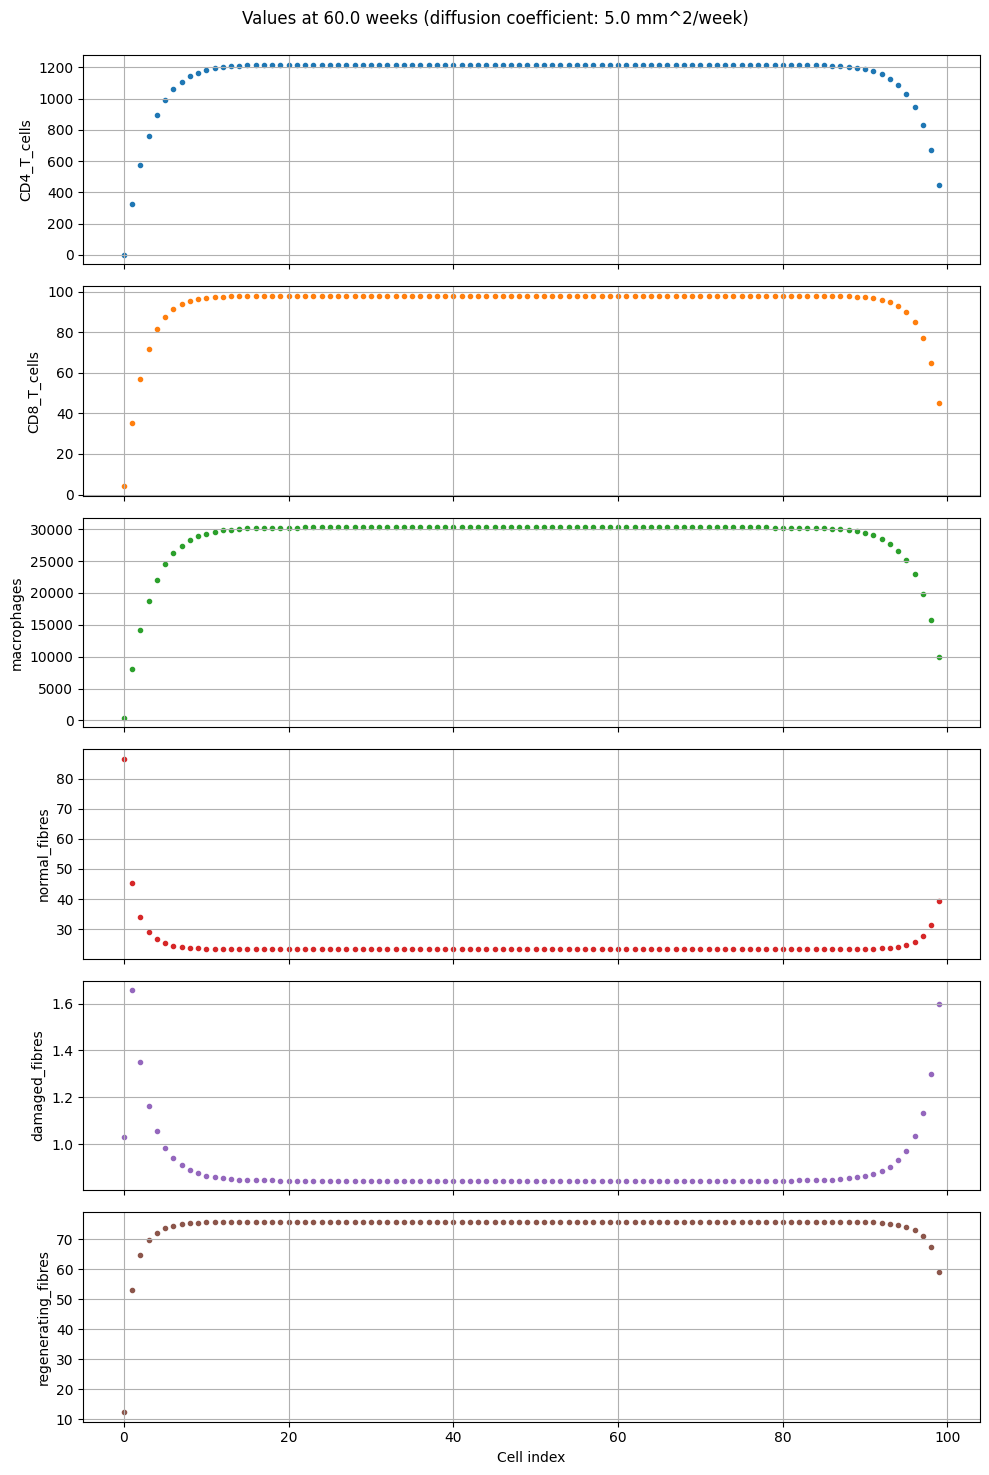

In [165]:
if boundary in ['fixed_asym', 'evolving_asym']:
    directory = f'{N_cells}_cells_{boundary}/icr{i_c_r}_icl{i_c_l}/{t_max}_weeks_diff_{diffusion[0]}/'
elif boundary == 'fixed_sym':
    directory = f'{N_cells}_cells_{boundary}/ic{i_c_l}/{t_max}_weeks_diff_{diffusion[0]}/'

os.makedirs(directory, exist_ok=True)
    
cells = np.linspace(0, N_cells, N_cells+1)
values_lists = [H_values, C_values, M_values, N_values, D_values, R_values]

fig, axes = plt.subplots(N_VARS, 1, figsize=(10, 15), sharex=True)

for i, ax in enumerate(axes):
    for j in range(N_cells):
        ax.scatter(cells[j], values_lists[i][-1][j], color=f'C{i}', marker='.')  #use consistent color for each subplot
    ax.set_ylabel(labels[i])
    ax.grid(True)

axes[-1].set_xlabel('Cell index')

fig.suptitle(f'Values at {t_max} weeks (diffusion coefficient: {diffusion[0]} mm^2/week)')
plt.tight_layout()
plt.subplots_adjust(top=0.95)

#filepath = os.path.join(directory,f'{N_cells}_cells_values_at_{t_max}_weeks_with_diffusion_{diffusion[0]}.png')
#plt.savefig(filepath)

plt.show()

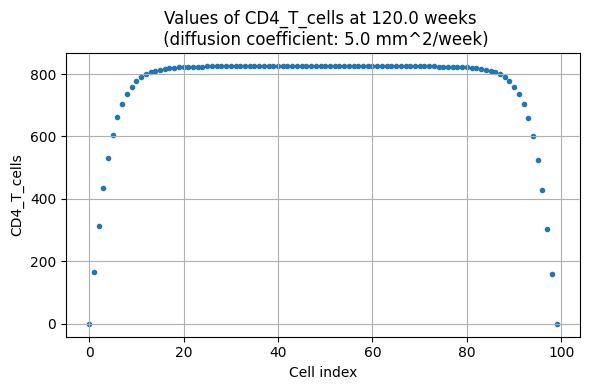

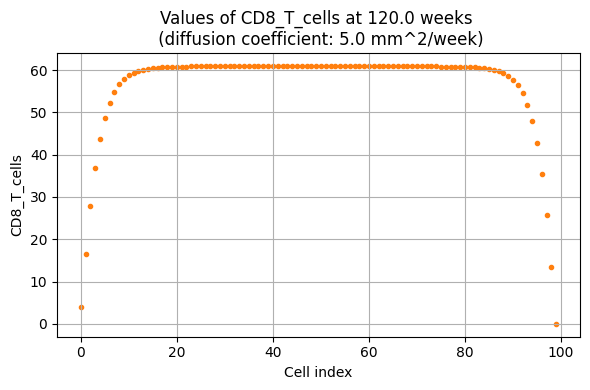

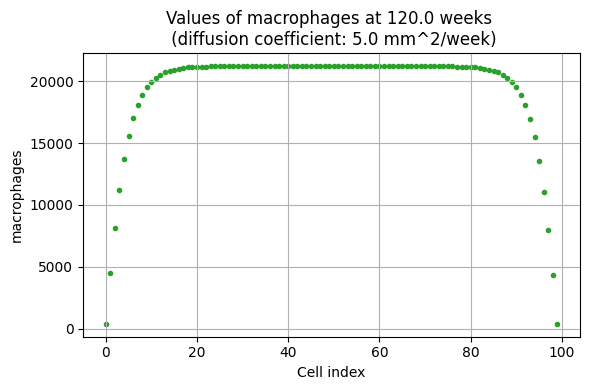

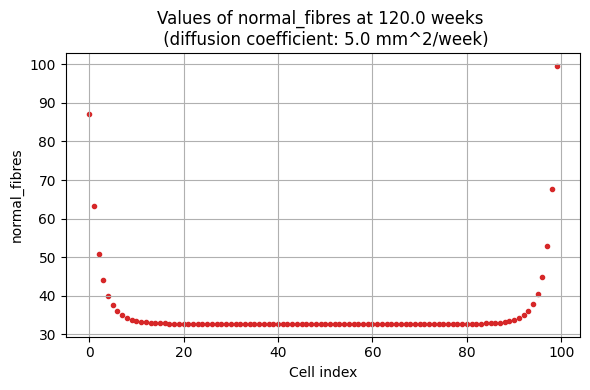

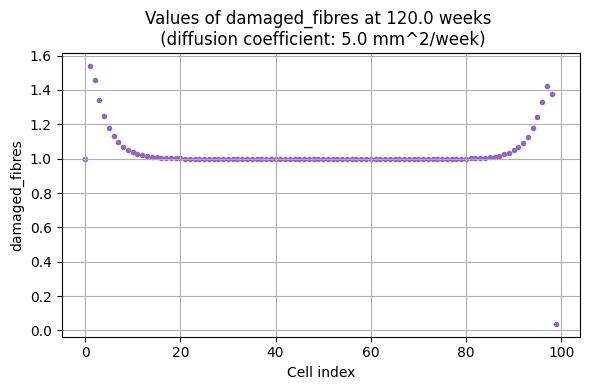

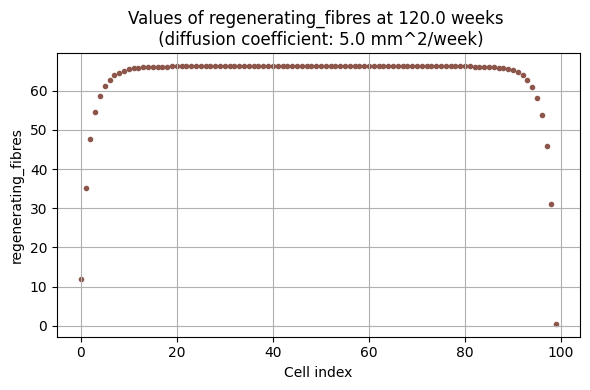

In [147]:
# Lists for values corresponding to each variable
values_lists = [H_values, C_values, M_values, N_values, D_values, R_values]

#Specify which plot to save
save_index = 0
save_path = "desired_plot.png"  # Specify the save path

# Create individual figures for each variable
for i in range(N_VARS):
    plt.figure(figsize=(6, 4))  # Create a new figure for each variable
    for j in range(N_cells):
        # Scatter plot for the specific variable
        plt.scatter(cells[j], values_lists[i][-1][j], color=f"C{i}", marker='.')
    
    # Set labels and grid
    plt.xlabel('Cell index')
    plt.ylabel(labels[i])
    plt.grid(True)
    
    # Add a title for clarity (optional)
    plt.title(f'Values of {labels[i]} at {t_max} weeks \n (diffusion coefficient: {diffusion[0]} mm^2/week)')
    
    # Save only the desired plot
    if i == save_index:
        plt.savefig(save_path, dpi=300)  # Save with high resolution
    
    # Show the plot
    plt.tight_layout()
    plt.show()


The following cell generates a plot of the evolution in the second, third, fiftieth, third-to-last and penultimate cell of the row.

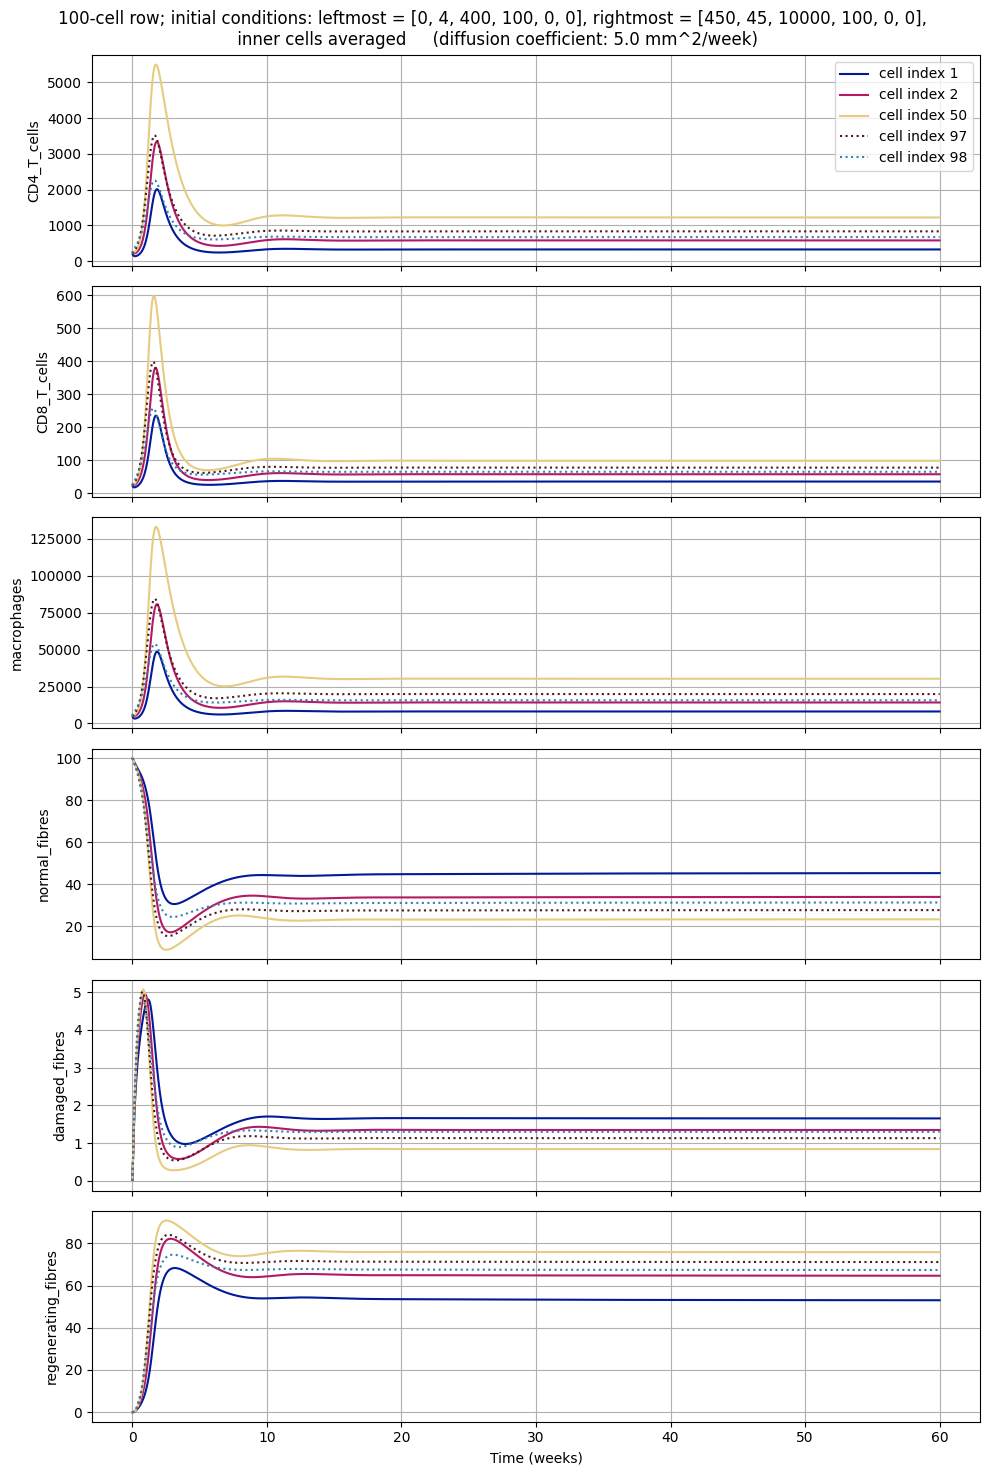

In [166]:
'''Use list comprehensions to extract the second column, representing the evolution of the second cell.
With uniform initialization, this cell's evolution is representative of the others under certain boundary conditions.
However, if edge cells are fixed or initialized differently, the evolution of additional cells should also be studied.'''
column_H_1 = [row[1] for row in H_values]
column_C_1 = [row[1] for row in C_values]
column_M_1 = [row[1] for row in M_values]
column_N_1 = [row[1] for row in N_values]
column_D_1 = [row[1] for row in D_values]
column_R_1 = [row[1] for row in R_values]

if boundary in ['fixed_sym', 'fixed_asym', 'evolving_asym']:
    column_H_2 = [row[2] for row in H_values]
    column_C_2 = [row[2] for row in C_values]
    column_M_2 = [row[2] for row in M_values]
    column_N_2 = [row[2] for row in N_values]
    column_D_2 = [row[2] for row in D_values]
    column_R_2 = [row[2] for row in R_values]

    middle_index = int(0.5 * N_cells) 
    column_H_mid = [row[middle_index] for row in H_values]
    column_C_mid = [row[middle_index] for row in C_values]
    column_M_mid = [row[middle_index] for row in M_values]
    column_N_mid = [row[middle_index] for row in N_values]
    column_D_mid = [row[middle_index] for row in D_values]
    column_R_mid = [row[middle_index] for row in R_values]

    column_H_minus_3 = [row[-3] for row in H_values]
    column_C_minus_3 = [row[-3] for row in C_values]
    column_M_minus_3 = [row[-3] for row in M_values]
    column_N_minus_3 = [row[-3] for row in N_values]
    column_D_minus_3 = [row[-3] for row in D_values]
    column_R_minus_3 = [row[-3] for row in R_values]
    
    column_H_minus_2 = [row[-2] for row in H_values]
    column_C_minus_2 = [row[-2] for row in C_values]
    column_M_minus_2 = [row[-2] for row in M_values]
    column_N_minus_2 = [row[-2] for row in N_values]
    column_D_minus_2 = [row[-2] for row in D_values]
    column_R_minus_2 = [row[-2] for row in R_values]    

cell_1 = [column_H_1, column_C_1, column_M_1, column_N_1, column_D_1, column_R_1]
cell_2 = [column_H_2, column_C_2, column_M_2, column_N_2, column_D_2, column_R_2]  
cell_mid = [column_H_mid, column_C_mid, column_M_mid, column_N_mid, column_D_mid, column_R_mid]  
cell_minus_3 = [column_H_minus_3, column_C_minus_3, column_M_minus_3, column_N_minus_3, column_D_minus_3, column_R_minus_3]  
cell_minus_2 = [column_H_minus_2, column_C_minus_2, column_M_minus_2, column_N_minus_2, column_D_minus_2, column_R_minus_2]  

fig, axes = plt.subplots(N_VARS, 1, figsize=(10, 15), sharex=True)

for i in range(N_VARS):
    axes[i].plot(t, cell_1[i], label=f'cell index {1}', color=(0.0, 0.1, 0.6))
    if boundary in ['fixed_sym', 'fixed_asym', 'evolving_asym']:
        axes[i].plot(t, cell_2[i], label=f'cell index {2}', color=(0.7, 0.1, 0.4))
        axes[i].plot(t, cell_mid[i], label=f'cell index {middle_index}', color=(0.9, 0.8, 0.5))
        axes[i].plot(t, cell_minus_3[i], label=f'cell index {N_cells - 3}', color=(0.3, 0.1, 0.1), linestyle=':')
        axes[i].plot(t, cell_minus_2[i], label=f'cell index {N_cells - 2}', color=(0.2, 0.5, 0.7), linestyle=':')
    axes[i].set_ylabel(labels[i])
    axes[i].grid(True)

axes[-1].set_xlabel('Time (weeks)')
axes[0].legend()

i_c_l_int = [int(value) for value in i_c_l]
i_c_r_int = [int(value) for value in i_c_r]

if boundary in ['fixed_asym', 'evolving_asym']:
    fig.suptitle(f'{N_cells}-cell row; initial conditions: \
leftmost = {i_c_l_int}, rightmost = {i_c_r_int}, \n inner cells averaged \
    (diffusion coefficient: {diffusion[0]} mm^2/week)')
elif boundary == 'fixed_sym':
    fig.suptitle(f'{N_cells}-cell row, uniform initialisation {i_c_l} \n \
    (diffusion coefficient: {diffusion[0]} mm^2/week)')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

filepath = os.path.join(directory,'cells_2_3_middle_with_mirror.png')
plt.savefig(filepath)

plt.show()